## Process ERA5 regions ##

For each DNO region, process the daily max wind gust and total precipitation, 
to visualise alongside the fault data for each DNO region.

In [1]:
import os
import sys
import glob

import numpy as np
import iris
import cftime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry
import cartopy.io.shapereader as shpreader

# Specific imports
from tqdm import tqdm
from typing import List, Tuple, Dict, Any, Optional
from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress
from mpl_toolkits.axes_grid1 import make_axes_locatable

# standard libraries
from pathlib import Path

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the path to all of the files
wg_files_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/SOTCES/ERA5_EU_SOTCES_202*_*_wind_gust.nc"

# Load in the cubes
cubes = iris.load(wg_files_path, "fg10")

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/netcdf/loader.py:233: IrisLoadWarning: NetCDF variable `expver` is a variable length type of kind <class 'str'> thus the total data size cannot be known in advance. This may affect the lazy loading of the data.
  warnings.warn(msg, category=iris.warnings.IrisLoadWarning)


In [3]:
cubes

[<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 672; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>]

In [4]:
shapefile_paths = {
    "DNO": Path("/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp")
}

In [5]:
# Read in NESO's DNO shapefile with geopandas
dno_shapes = gpd.read_file(shapefile_paths["DNO"])

In [6]:
# print the head of the df
print("DNO Shapes DataFrame:")
print(dno_shapes.head())

DNO Shapes DataFrame:
                                            geometry
0  MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...
1  POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...
2  POLYGON ((-0.24419 51.48844, -0.24509 51.48926...
3  MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....
4  POLYGON ((-1.95899 53.21664, -1.95676 53.21383...


In [7]:
# Expanded DNO Shapes DataFrame
expanded_dno_shapes = pd.DataFrame({
    "ID": [10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 18, 20],
    "Name": ["_A", "_B", "_C", "_D", "_E", "_F", "_G", "_P", "_J", "_K", "_L", "_M", "_N", "_H"],
    "DNO": ["UKPN", "NGED", "UKPN", "SPEN", "NGED", "NPG", "ENWL", "SSEN", "UKPN", "NGED", "NGED", "NPG", "SPEN", "SSEN"],
    "Area": [
        "East England", "East Midlands", "London", "North Wales, Merseyside and Cheshire",
        "West Midlands", "North East England", "North West England", "North Scotland",
        "South East England", "South Wales", "South West England", "Yorkshire",
        "South and Central Scotland", "Southern England"
    ],
    "DNO_Full": [
        "UK Power Networks", "National Grid Electricity Distribution", "UK Power Networks",
        "SP Energy Networks", "National Grid Electricity Distribution", "Northern Powergrid",
        "Electricity North West", "Scottish and Southern Electricity Networks", "UK Power Networks",
        "National Grid Electricity Distribution", "National Grid Electricity Distribution",
        "Northern Powergrid", "SP Energy Networks", "Scottish and Southern Electricity Networks"
    ],
})

# Print the expanded DataFrame
print("Expanded DNO Shapes DataFrame:")
print(expanded_dno_shapes)

# add these columns to the dno_shapes GeoDataFrame
for col in expanded_dno_shapes.columns:
    if col not in dno_shapes.columns:
        dno_shapes[col] = expanded_dno_shapes[col].values

Expanded DNO Shapes DataFrame:
    ID Name   DNO                                  Area  \
0   10   _A  UKPN                          East England   
1   11   _B  NGED                         East Midlands   
2   12   _C  UKPN                                London   
3   13   _D  SPEN  North Wales, Merseyside and Cheshire   
4   14   _E  NGED                         West Midlands   
5   15   _F   NPG                    North East England   
6   16   _G  ENWL                    North West England   
7   17   _P  SSEN                        North Scotland   
8   19   _J  UKPN                    South East England   
9   21   _K  NGED                           South Wales   
10  22   _L  NGED                    South West England   
11  23   _M   NPG                             Yorkshire   
12  18   _N  SPEN            South and Central Scotland   
13  20   _H  SSEN                      Southern England   

                                      DNO_Full  
0                            UK Po

In [8]:
dno_shapes.head()

,geometry,ID,Name,DNO,Area,DNO_Full
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...",10,_A,UKPN,East England,UK Power Networks
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...",11,_B,NGED,East Midlands,National Grid Electricity Distribution
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926...",12,_C,UKPN,London,UK Power Networks
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....",13,_D,SPEN,"North Wales, Merseyside and Cheshire",SP Energy Networks
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383...",14,_E,NGED,West Midlands,National Grid Electricity Distribution


Text(119.83491205934631, 0.5, 'Latitude')

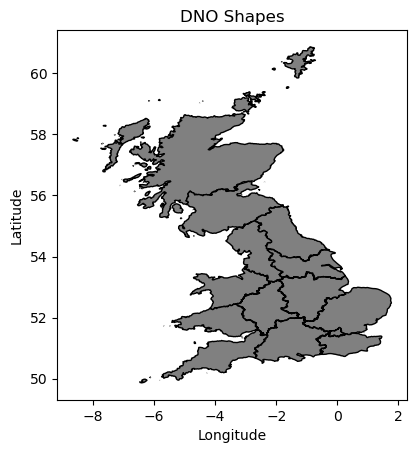

In [9]:
# Try plotting north west england first
dno_shapes.plot(
    color='grey',
    edgecolor='black',
    linewidth=1,
)
plt.title("DNO Shapes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

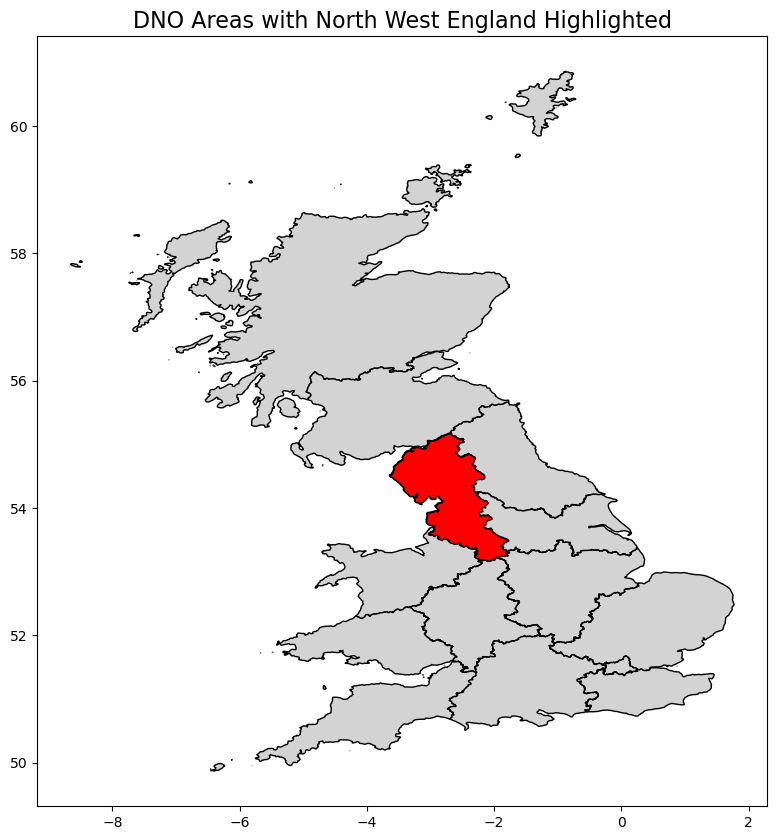

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter the GeoDataFrame for "North West England"
north_west_england = dno_shapes[dno_shapes["DNO"] == "ENWL"]

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
dno_shapes.plot(ax=ax, color="lightgrey", edgecolor="black")  # Plot all areas in light grey
north_west_england.plot(ax=ax, color="red", edgecolor="black")  # Highlight North West England in red

# Add title and labels
ax.set_title("DNO Areas with North West England Highlighted", fontsize=16)
plt.show()

In [11]:
# %%time

# # Set up the lons and lats
# lons = cube.coord('longitude').points
# lats = cube.coord('latitude').points

# # extract the time points
# time_points = cube.coord('time').points

# # Set up the x, y
# x, y = lons, lats

# # extract the values of the cube
# values_fg10 = cube.data

# # # print the lons and lats
# # print(f"Longitude points: {x}")
# # print(f"Latitude points: {y}")
# # # Set up the time points
# # print(f"Time points: {time_points}")

In [12]:
%%time

# Extract the lons and lats from the first cube
lons = cubes[0].coord('longitude').points
lats = cubes[0].coord('latitude').points

# Set up an empty list to hold the dfs
dfs_wind_gust = []

# Loop through the cubes and extract the data
for cube in tqdm(cubes):
    # Extract the time points
    time_points = cube.coord('time').points

    # Extract the values of the cube
    values_fg10 = cube.data

    # Set up an empty dataframe wih the time points as the index
    df = pd.DataFrame(index=(time_points))

    # Loop over the rows in dno_shapes and extract the values for each DNO
    for index, row in dno_shapes.iterrows():
        mask_matrix_this = np.zeros(
            (len(time_points),
                len(lats),
                len(lons)),
        )

        # Loop over the lats and lons
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                point = shapely.geometry.Point(lons[j], lats[i])  # Replace 'l' with 'i'
                if row.geometry.contains(point):
                    # Extract the time series for this point
                    time_series_this_point = values_fg10[:, i, j]  # Replace 'l' with 'i'
                    # Add the time series to the mask matrix
                    mask_matrix_this[:, i, j] = time_series_this_point

        # Reshape the mask matrix into a time series by finding the max
        # value at each time point
        mask_matrix_this_max = np.max(mask_matrix_this, axis=(1, 2))

        # Add the time series to the dataframe
        df[row["Area"]] = mask_matrix_this_max

    # Append the dataframe to the list
    dfs_wind_gust.append(df)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:54<00:00,  8.83s/it]

CPU times: user 1min 42s, sys: 4.63 s, total: 1min 47s
Wall time: 1min 54s


In [13]:
dfs_wind_gust[0].head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
1711929600,5.918596,11.392228,2.930315,10.759416,9.441056,13.986955,14.412736,12.590470,10.076798,10.310197,8.810197,12.737931,11.925431,8.440080
1711933200,5.454466,10.771849,4.167357,10.269896,8.377317,13.869505,14.226927,12.709349,9.716185,9.734739,8.619505,12.326536,12.968138,8.307981
1711936800,6.199211,10.352531,5.716789,10.206047,8.068352,14.336906,14.049797,13.022453,10.431633,8.965813,7.131828,12.317375,12.763664,7.894523
1711940400,6.990768,9.764206,6.633346,10.100143,8.081589,14.274948,13.846237,13.535690,10.727097,8.258347,6.338424,12.395065,13.652878,7.938034
1711944000,7.247946,9.493064,7.439353,9.699119,7.802634,13.029197,13.045798,14.207908,10.676658,7.018454,6.414938,12.077048,14.197165,7.993063


In [14]:
# Loop over the dfs wind gust
for i, df in enumerate(dfs_wind_gust):
    # Set the index to a datetime index
    df.index = pd.to_datetime(df.index, unit='s', origin='1970-01-01')

In [15]:
dfs_wind_gust[0].tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-30 19:00:00,9.061892,10.684938,7.786501,9.957399,9.209352,11.905642,11.784548,16.152712,8.277712,10.150759,7.647829,10.902712,13.543337,8.288454
2024-04-30 20:00:00,8.567490,9.116318,5.998153,8.653427,7.580184,11.583115,9.367294,15.374130,7.908309,9.373154,7.133895,9.596786,11.885849,7.679794
2024-04-30 21:00:00,7.667079,9.017666,6.423915,8.131924,6.992275,10.496181,8.141689,14.362392,8.209072,8.794033,6.858486,8.888760,11.282314,7.697353
2024-04-30 22:00:00,7.114398,7.814593,6.576312,7.392718,6.327289,8.937640,7.659320,13.449359,8.353656,8.062640,6.987445,8.597796,10.464007,7.762836
2024-04-30 23:00:00,7.206179,7.415163,6.534304,6.713015,6.122194,8.098757,6.771608,13.299929,8.228640,7.413210,7.338991,7.778444,9.302858,7.202272


In [16]:
# Join the dataframes together on the index
df_wind_gust = pd.concat(dfs_wind_gust, axis=0)

In [17]:
# Sort the index of these
df_wind_gust = df_wind_gust.sort_index()

In [18]:
df_wind_gust.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-01 00:00:00,5.918596,11.392228,2.930315,10.759416,9.441056,13.986955,14.412736,12.590470,10.076798,10.310197,8.810197,12.737931,11.925431,8.440080
2024-04-01 01:00:00,5.454466,10.771849,4.167357,10.269896,8.377317,13.869505,14.226927,12.709349,9.716185,9.734739,8.619505,12.326536,12.968138,8.307981
2024-04-01 02:00:00,6.199211,10.352531,5.716789,10.206047,8.068352,14.336906,14.049797,13.022453,10.431633,8.965813,7.131828,12.317375,12.763664,7.894523
2024-04-01 03:00:00,6.990768,9.764206,6.633346,10.100143,8.081589,14.274948,13.846237,13.535690,10.727097,8.258347,6.338424,12.395065,13.652878,7.938034
2024-04-01 04:00:00,7.247946,9.493064,7.439353,9.699119,7.802634,13.029197,13.045798,14.207908,10.676658,7.018454,6.414938,12.077048,14.197165,7.993063


In [19]:
# Set up the fname for this
fname = "max_10m_wind_gusts_timeseries_DNO_areas_Apr_2024-Apr_2025.csv"

# Set up the directory in which to save this
output_dir = Path("/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs")

# Make the directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# if the full path does not exist
if not os.path.exists(os.path.join(output_dir, fname)):
    # Save the dataframe to a csv file
    df_wind_gust.to_csv(os.path.join(output_dir, fname))

### Plot the wind gust for the year ###

And also mark the storms on this as well

In [20]:
# Process the dataframe to take the max value for each day
df_wind_gust_daily_max = df_wind_gust.resample('D').max()

In [21]:
# Print the columns of the dataframe
print("Columns in the DataFrame:")
print(df_wind_gust_daily_max.columns)

Columns in the DataFrame:
Index(['East England', 'East Midlands', 'London',
       'North Wales, Merseyside and Cheshire', 'West Midlands',
       'North East England', 'North West England', 'North Scotland',
       'South East England', 'South Wales', 'South West England', 'Yorkshire',
       'South and Central Scotland', 'Southern England'],
      dtype='object')


In [22]:
# Set up a dictionary for the storms ordered by date
storms = {
    "Storm Henk": ["2024-01-02", "2024-01-02"],
    "Storm Isha": ["2024-01-19", "2024-01-22"],
    "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
}

# Set up different colours for the storms (ordered to match)
storm_colours = {
    "Storm Henk": "cyan",
    "Storm Isha": "magenta",
    "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
}

region_colors = {
    'East England': 'tab:blue',
    'East Midlands': 'tab:orange',
    'London': 'tab:green',
    'North Wales, Merseyside and Cheshire': 'tab:red',
    'West Midlands': 'tab:purple',
    'North East England': 'tab:brown',
    'North West England': 'tab:pink',
    'North Scotland': 'tab:gray',
    'South East England': 'tab:olive',
    'South Wales': 'tab:cyan',
    'South West England': 'gold',
    'Yorkshire': 'teal',
    'South and Central Scotland': 'navy',
    'Southern England': 'magenta'
}

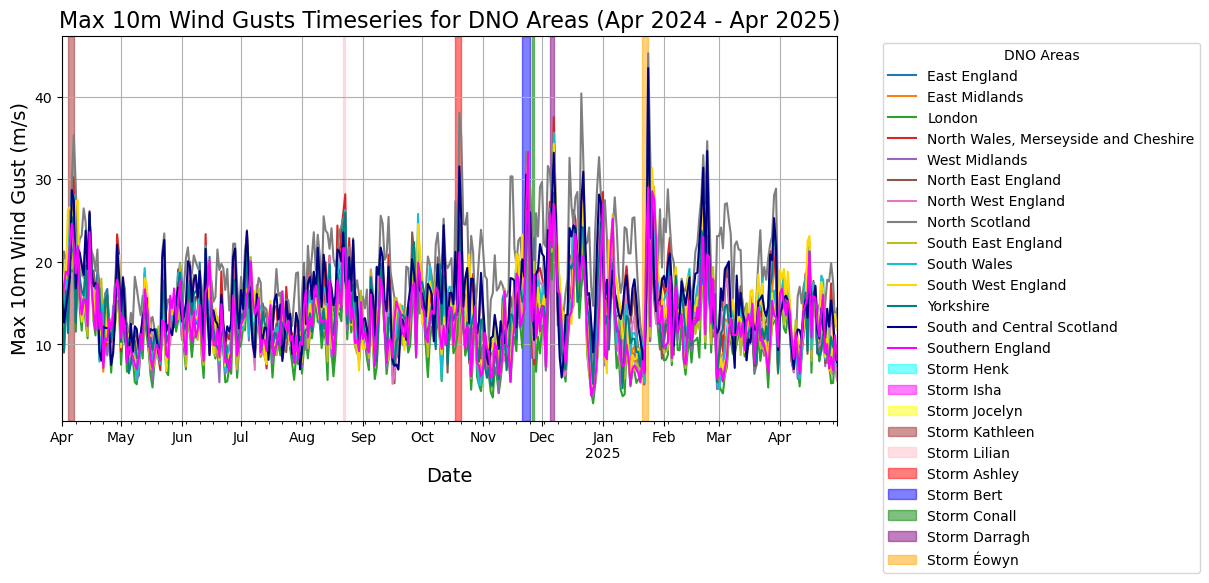

In [23]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Loop over the columns in the dataframe
for col in df_wind_gust_daily_max.columns:
    # Plot the data for this column
    df_wind_gust_daily_max[col].plot(
        ax=ax,
        label=col,
        color=region_colors.get(col, 'black'),  # Use black if the region is not in the colors dict
        linewidth=1.5
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

    plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)


# Set the title and labels
ax.set_title("Max 10m Wind Gusts Timeseries for DNO Areas (Apr 2024 - Apr 2025)", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Max 10m Wind Gust (m/s)", fontsize=14)
ax.legend(title="DNO Areas", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True)


In [24]:
# From the daily max for each DNO area, find the max value for each day across all DNO areas
df_wind_gust_daily_max_overall = df_wind_gust_daily_max.max(axis=1)

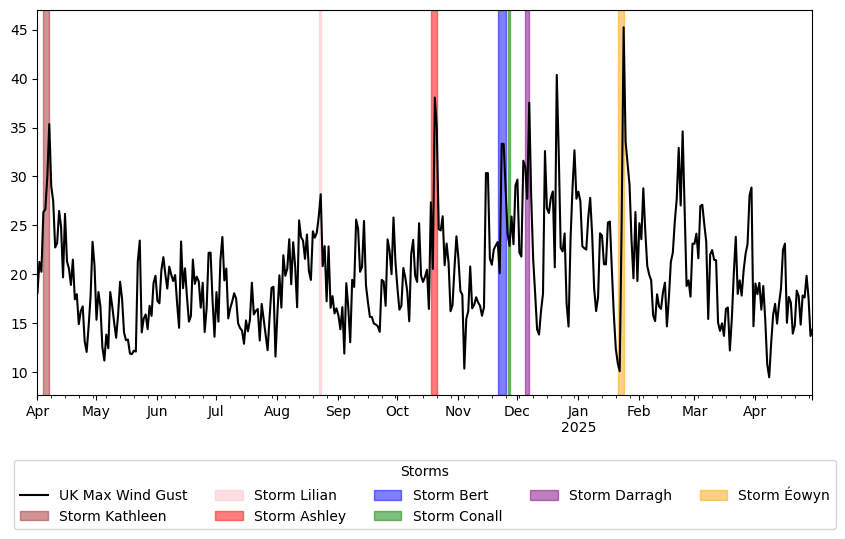

In [25]:
# Plot the overall max wind gusts
fig, ax = plt.subplots(figsize=(10, 5))

df_wind_gust_daily_max_overall.plot(
    ax=ax,
    label="UK Max Wind Gust",
    color='black',
    linewidth=1.5
)

# If the storms are within the date range of the dataframe, plot them
for storm, dates in storms.items():
    if pd.to_datetime(dates[0]).tz_localize(None) >= df_wind_gust_daily_max_overall.index.min() and \
       pd.to_datetime(dates[1]).tz_localize(None) <= df_wind_gust_daily_max_overall.index.max():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)
        end_date = pd.to_datetime(dates[1]).tz_localize(None)
        plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)


# Include the legend horizontally beneath the plot
ax.legend(title="Storms", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5, fontsize=10)

Now do the same but for accumulated daily precipitation during January 2025

In [26]:
# Set up the paths to the precipitation files
precip_paths = glob.glob("/gws/nopw/j04/canari/users/benhutch/ERA5/SOTCES/ERA5_EU_SOTCES_202*_*total_precip.nc")

# load multiple cubes
cubes = iris.load(precip_paths, "tp")

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/netcdf/loader.py:233: IrisLoadWarning: NetCDF variable `expver` is a variable length type of kind <class 'str'> thus the total data size cannot be known in advance. This may affect the lazy loading of the data.
  warnings.warn(msg, category=iris.warnings.IrisLoadWarning)


In [27]:
# print the min and max time of the second last cube and last cube
print(f"Second last cube time range: {cubes[-2].coord('time').points.min()} to {cubes[-2].coord('time').points.max()}")
print(f"Last cube time range: {cubes[-1].coord('time').points.min()} to {cubes[-1].coord('time').points.max()}")

Second last cube time range: 1740787200 to 1743462000
Last cube time range: 1743465600 to 1746054000


In [29]:
# extract the time points of the final cube
time_points_precip = cubes[-1].coord('time').points

# convert the time points to datetime
time_points_precip = pd.to_datetime(time_points_precip, unit='s', origin='1970-01-01')

# print the min and max of these
print(f"Time points precip min: {time_points_precip.min()}")
print(f"Time points precip max: {time_points_precip.max()}")

Time points precip min: 2025-04-01 00:00:00
Time points precip max: 2025-04-30 23:00:00


In [30]:
%%time

# extrcat the lons of the first cube
lons_precip = cubes[0].coord('longitude').points
lats_precip = cubes[0].coord('latitude').points

# set up an empty list to hold the dfs
dataframes_precip = []

# loop over the cubes
for cube_precip in cubes:
    # Extract the time points this
    time_points_precip_this = cube_precip.coord('time').points

    # extract the values thi
    values_tp_this = cube_precip.data

    # Set up an empty dataframe
    dataframe_full_precip_this = pd.DataFrame(index=(time_points_precip_this))

    # Loop over the rows in dno_shapes and extract time series for each DNO area
    for index, row in tqdm(dno_shapes.iterrows(), total=len(dno_shapes)):
        mask_matrix_this_dno_precip = np.zeros((len(time_points_precip_this), len(lats_precip), len(lons_precip)))

        for l in range(len(lats_precip)):
            for j in range(len(lons_precip)):
                point = shapely.geometry.Point(lons_precip[j], lats_precip[l])
                if row.geometry.contains(point):
                    # Extract the time series for this point
                    time_series_this_point = values_tp_this[:, l, j]
                    # Add the time series to the mask matrix
                    mask_matrix_this_dno_precip[:, l, j] = time_series_this_point

        # Reshape the mask matrix into a time series by summing the values at each time point
        time_series_sum = np.sum(mask_matrix_this_dno_precip, axis=(1, 2))
        # Add the time series to the dataframe
        dataframe_full_precip_this[row['Area']] = time_series_sum

    # Append the dataframe to the list
    dataframes_precip.append(dataframe_full_precip_this)

100%|██████████| 14/14 [00:07<00:00,  1.81it/s]

CPU times: user 1min 41s, sys: 12.5 s, total: 1min 53s
Wall time: 1min 56s


In [31]:
# loop over the dataframes precip
for i, df in enumerate(dataframes_precip):
    # convert all columns from m to mm
    dataframes_precip[i] = df * 1000  # Convert from meters to millimeters

    # Convert the index to datetime
    dataframes_precip[i].index = pd.to_datetime(dataframes_precip[i].index, unit='s', origin='1970-01-01')

In [32]:
dataframes_precip[4]

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-08-01 00:00:00,0.000000,0.000000,0.000000,2.895355,1.112938,0.026703,0.052452,3.448486,1.324654,3.057480,2.304077,0.000954,15.069008,2.383232
2024-08-01 01:00:00,0.000000,0.004768,0.000000,10.373116,6.384850,0.194550,0.749588,4.710197,0.011444,2.552986,8.215904,0.020981,16.462326,5.231857
2024-08-01 02:00:00,0.000477,0.803471,0.000000,15.545845,6.723404,2.039909,5.829334,10.320663,0.000000,3.953934,15.370846,1.270294,20.155907,2.581120
2024-08-01 03:00:00,0.000477,2.651691,0.000000,11.594772,11.087418,6.439209,9.341240,10.433674,0.000000,4.544258,7.111073,4.932880,23.644924,1.035690
2024-08-01 04:00:00,0.102997,6.370068,0.000000,6.693840,9.183884,5.929947,8.202553,11.804104,0.375271,2.656460,0.225544,5.742550,18.362999,3.147602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,0.016689,0.008106,0.004768,0.000000,0.000000,0.001907,0.000000,0.000000,0.050068,0.000000,0.020027,0.000477,0.000000,0.188351
2024-08-31 20:00:00,0.006676,0.000000,0.002384,0.000000,0.000000,0.000000,0.000000,0.000000,0.015736,0.000000,0.019073,0.000000,0.000000,0.152111
2024-08-31 21:00:00,2.818584,0.001907,0.003815,0.000000,0.000477,0.006199,0.000000,0.000000,0.011444,0.004768,0.010967,0.000000,0.000000,0.164032
2024-08-31 22:00:00,0.020027,0.061512,0.002384,0.004292,0.012398,0.006676,0.000000,0.000000,0.000477,0.010490,0.034809,0.000000,0.000000,0.152111


In [33]:
# join the dataframes together on the index
dataframe_full_precip = pd.concat(dataframes_precip, axis=0)

In [34]:
dataframe_full_precip.tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-04-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.332802,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-30 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.081509,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.419369,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.550167,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.584167,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# order the index correctly as time from oldest to newest
dataframe_full_precip = dataframe_full_precip.sort_index()

In [37]:
dataframe_full_precip.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-01 00:00:00,6.006241,2.311707,0.907898,0.650406,3.840446,14.388084,7.496834,0.005722,1.893997,18.601418,5.331993,10.083199,0.073433,9.266853
2024-04-01 01:00:00,6.605148,2.391815,0.576973,0.416756,4.136086,15.438080,11.138916,0.012398,0.896454,24.639130,1.589775,11.964798,4.030228,7.308006
2024-04-01 02:00:00,7.979393,3.082275,0.235558,0.649452,5.788803,12.709618,8.423805,0.031471,0.321388,22.900581,0.453949,10.106087,2.239227,5.211830
2024-04-01 03:00:00,12.660027,4.703522,0.247002,0.628471,6.783485,11.034012,3.407478,0.065804,0.030518,13.250351,0.093460,8.889198,9.485245,3.031731
2024-04-01 04:00:00,6.763458,7.118225,0.021935,1.270294,7.377625,8.786201,2.629280,0.092506,0.000000,7.081985,0.527382,6.866455,3.798485,1.151085


In [38]:
# Set up the fname for this
fname_this_precip = "total_precip_timeseries_dno_areas_April_2024-April_2025.csv"

# if the full path does not exist, then save it
if not os.path.exists(os.path.join(output_dir, fname_this_precip)):
    print(f"Saving dataframe to {os.path.join(output_dir, fname_this_precip)}")
    dataframe_full_precip.to_csv(os.path.join(output_dir, fname_this_precip))

Saving dataframe to /home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/total_precip_timeseries_dno_areas_April_2024-April_2025.csv


In [39]:
# Quantify the daily accumulated precipitation
dataframe_full_precip_daily_accumulated = dataframe_full_precip.resample('D').sum()

In [42]:
dataframe_full_precip_daily_accumulated.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-01,81.107140,98.219872,7.688999,157.580376,152.659416,199.261665,213.886738,235.219002,27.765274,161.597729,112.418175,97.970486,316.870689,114.095211
2024-04-02,190.927505,172.485352,10.207653,85.284710,120.962143,57.999134,64.515591,586.080551,107.285500,207.299232,182.707787,39.518356,148.329258,210.137844
2024-04-03,126.930714,167.734623,7.888317,117.746830,84.994316,409.587383,288.489819,732.031822,56.022167,98.154545,97.821236,142.583370,592.640400,132.707596
2024-04-04,329.410076,280.843258,9.161949,191.769600,207.236767,75.955391,145.050049,222.487926,63.932419,236.249447,238.704205,136.952877,83.620548,191.724777
2024-04-05,104.649067,186.115742,2.614975,210.553169,127.697468,318.627357,336.961746,1529.036999,18.900394,261.828899,139.104366,195.540905,723.516941,122.112274


In [45]:
# # Set up a figure with 7 rows and 2 columns
# fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), sharex=True)

# # Loop through the columns in the dataframe
# for i, col in enumerate(dataframe_full_precip_daily_accumulated.columns):
#     # Get the current axis
#     ax = axes[i // 2, i % 2]

#     # Loop over and highlight the storm periods
#     for storm, dates in storms.items():
#         if pd.to_datetime(dates[0]).tz_localize(None) >= dataframe_full_precip_daily_accumulated.index.min() and \
#            pd.to_datetime(dates[1]).tz_localize(None) <= dataframe_full_precip_daily_accumulated.index.max():
#             start_date = pd.to_datetime(dates[0]).tz_localize(None)
#             end_date = pd.to_datetime(dates[1]).tz_localize(None)
#             ax.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)

#     # Plot the data for this column
#     dataframe_full_precip_daily_accumulated[col].plot(
#         ax=ax,
#         label=col,
#         color=region_colors.get(col, 'black'),  # Use black if the region is not in the colors dict
#         linewidth=1.5
#     )

#     # Set the title and labels for each subplot
#     ax.set_title(col, fontsize=12)
#     ax.set_xlabel("Date", fontsize=10)
#     ax.set_ylabel("Total Precipitation (mm)", fontsize=10)
#     ax.grid(True)


In [47]:
# Sum the daily accumulated precipitation across all DNO areas
dataframe_full_precip_daily_accumulated_overall = dataframe_full_precip_daily_accumulated.sum(axis=1)

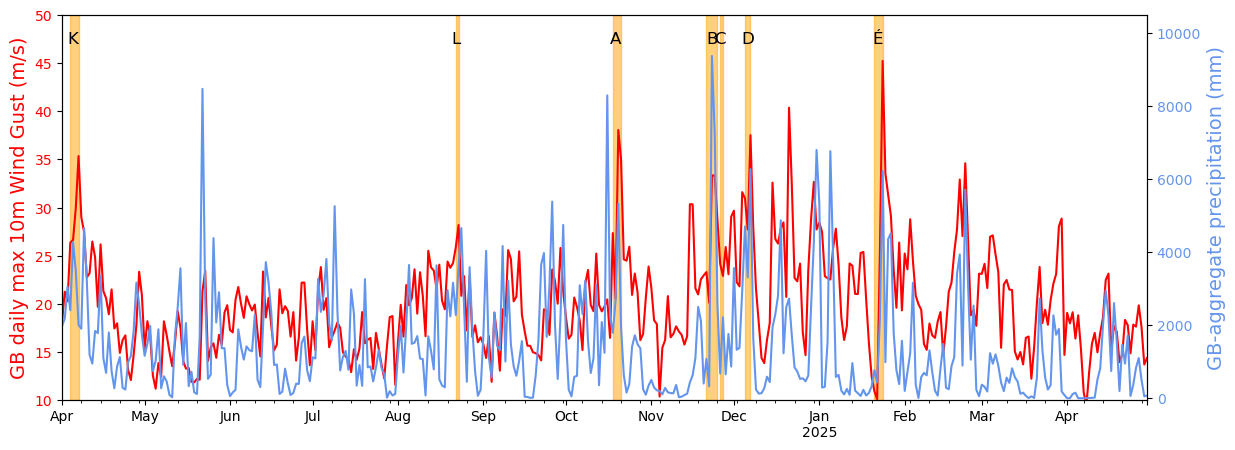

In [ ]:
# ---------------------
# Try to replicate Hannah's plot
# ---------------------

# Set the xsize and ysize
xsize = 14
ysize = 5

# Set up the figure
fig, ax = plt.subplots(figsize=(xsize, ysize))

# Set up the axes
ax1_b = ax.twinx()  # Create a second y-axis

# Plot the daily max wind gust for the UK
df_wind_gust_daily_max_overall.plot(
    ax=ax,
    label="UK Max Wind Gust",
    color='red',
)

# Set up the ylabel for this
ax.set_ylabel("GB daily max 10m Wind Gust (m/s)", fontsize=14, color='red')

# Highlight the ticks in red
ax.tick_params(axis='y', labelcolor='red')

# Plot the daily accumulated precipitation for all DNO areas
dataframe_full_precip_daily_accumulated_overall.plot(
    ax=ax1_b,
    label="UK Total Daily Accumulated Precipitation",
    color='cornflowerblue',
)

# Set up the ylabel for this
ax1_b.set_ylabel("GB-aggregate precipitation (mm)", fontsize=14, color='cornflowerblue')

# Highlight the ticks in blue
ax1_b.tick_params(axis='y', labelcolor='cornflowerblue')

# Set the ylims for the duplicate y-axis
ax1_b.set_ylim(-50, 10500)

# Set the ylim for the main y-axis
ax.set_ylim(10, 50)

# Loop over and highlight the storm periods
for storm, dates in storms.items():
    if pd.to_datetime(dates[0]).tz_localize(None) >= dataframe_full_precip_daily_accumulated.index.min() and \
       pd.to_datetime(dates[1]).tz_localize(None) <= dataframe_full_precip_daily_accumulated.index.max():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)
        end_date = pd.to_datetime(dates[1]).tz_localize(None)
        ax.axvspan(start_date, end_date, color="orange", alpha=0.5, label=storm)

        # For each storm, add text at the top (0.95) with the first letter of the storm name
        ax.text(
            start_date + (end_date - start_date) / 2,
            0.95 * ax.get_ylim()[1],
            storm.split()[-1][0],  # First letter of the storm name (e.g., "H" from "Storm Henk")
            fontsize=12,
            color='black',
            ha='center',
            va='center'
            # Remove the transform parameter to use data coordinates
        )